In [1]:
import tensorflow as tf
import numpy as np
import argparse
import cv2
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from util import tile_images, restore_constants
from train import build
from read_dataset import read_dataset

In [3]:
constants = restore_constants('../../vae_models/constants.json')
image_size = tuple(constants.IMAGE_SIZE[:-1])

In [4]:
reconstruct, generate_from_latent, train = build(constants)

In [5]:
sess = tf.Session()
sess.__enter__()

In [6]:
saver = tf.train.Saver()
saver.restore(sess, '../../vae_models/pointtotarget/model.ckpt')

INFO:tensorflow:Restoring parameters from ../../vae_models/pointtotarget/model.ckpt


In [7]:
get_next, _ = read_dataset('../../p2t.npy', image_size, int(1e4), constants.BATCH_SIZE, constants.EPOCH)

In [8]:
train_iterator = get_next()
batch_images = np.array([next(train_iterator)[0]], dtype=np.float32) / 255.0

In [122]:
def latent_perturb(latent, num=10):
    latent_range = np.zeros((latent.shape[1], num))
    for idx, element in enumerate(latent[0]):
        latent_range[idx] = np.random.normal(loc=latent[0][idx], size=(num), scale=0.5)
    return latent_range

In [123]:
reconst, latent = reconstruct(batch_images)
latent_range = latent_perturb(latent, num=10)
latent_in_page = int(constants.LATENT_SIZE / 2)

In [137]:
image_rows_parent = []
for page in range(2):
    image_rows = []
    for i in range(latent_in_page):
        index = page * latent_in_page + i
        # change specific element of latent variable
        tiled_latent = np.tile(latent[0].copy(), (10, 1))
        tiled_latent[:,index] = latent_range[index]
        print(latent[0][index])
        print(latent_range[index])

        # reconstruct from latent variable
        reconst = generate_from_latent(tiled_latent)
        
        # tiling reconstructed images
        reconst_images = np.array(reconst * 255, dtype=np.uint8)
        # reconst_tiled_images = tile_images(reconst_images, row=1)
        # image_rows.append(reconst_tiled_images)
        reconst_images_mean = np.mean(reconst_images, axis=0)
        image_rows.append(reconst_images_mean)
        
    
    # show reconstructed images
    #image_rows = tile_images(np.array(image_rows), row=latent_in_page)
    #cv2.imshow('test{}'.format(page), image_rows)
    image_rows_parent.append(image_rows)

-0.66230744
[-1.44590416 -1.90929207 -0.22686338 -0.84217788 -0.93823026 -0.0030097
 -0.41567821 -0.43948809 -0.67175994 -0.4861127 ]
1.2888577
[ 0.81948343  2.02770051  1.26141816  0.7893116   1.60847463  1.45198246
  1.96223016  2.10056157 -0.02421573  0.34824078]
2.3039863
[3.00285462 2.23355575 2.38011326 3.25374075 3.32300681 2.28107975
 2.39284796 1.5612063  2.15869154 2.66275613]
-0.3196987
[-0.79257954 -0.74646915  0.26787968  0.41256842 -0.1624223   0.28454123
 -0.83441494 -0.87364739  0.0376106  -1.4136851 ]
-0.4632796
[-0.39288117  0.18775726 -0.07695357 -0.51576072 -1.40815698 -0.26517636
 -0.66915164 -1.29647441 -0.10188513 -0.61741138]
-0.9150492
[-1.11852493 -0.46912855 -1.26894899 -0.76169966 -0.86396461 -1.38249877
 -0.64508016 -0.59607134 -0.70071294 -0.04658175]
-1.8043722
[-1.93249809 -2.60552322 -1.85383276 -1.3983751  -1.82543731 -2.40296525
 -1.31260883 -1.80823229 -1.79916896 -1.62978365]
0.33098388
[ 0.55562399  1.16442331  0.801808   -0.99085266  0.07337052  0

In [140]:
image_rows_parent = np.array(image_rows_parent).reshape(-1, 64, 64, 3)

In [141]:
image_rows_parent.shape

(8, 64, 64, 3)

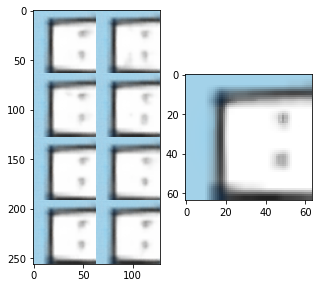

In [163]:
plt.figure(figsize=(5,10))
plt.subplot(121)
plt.imshow(tile_images(image_rows_parent))
plt.subplot(122)
plt.imshow(batch_images[0])

In [177]:
diff_image_rows_parent = image_rows_parent - np.tile(batch_images, (8, 1, 1, 1))
diff_image_rows_parent = np.abs(diff_image_rows_parent)

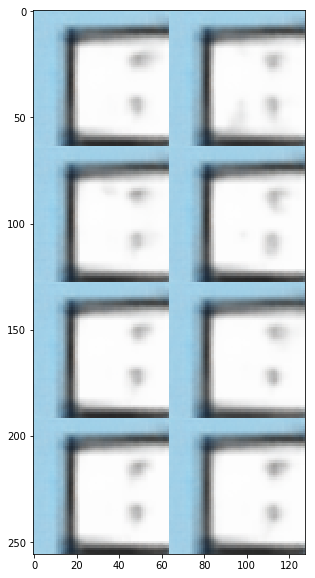

In [178]:
plt.figure(figsize=(5,10))
plt.imshow(tile_images(diff_image_rows_parent))